# PyTorch DataLoader 使用指南

深度學習-Pytorch手把手實作-資料庫: DataLoader example by pytorch  
在PyTorch中，`DataLoader`是處理資料集的重要工具。以下是使用PyTorch的`DataLoader`來處理官方提供的資料集（如torchvision）和自有資料集的系列操作。

## 目錄

1. [使用torchvision提供的資料集](#torchvision-dataset)
2. [處理私有資料庫](#private-dataset)
3. [將資料丟到CUDA](#data-to-cuda)

# torchvision 內建資料集

當使用PyTorch torchvision提供的資料集時，流程相對簡單。

### 步驟

1. **導入資料集模組** - 例如：`from torchvision.datasets import MNIST`
2. **設定資料集參數** - 包括下載、轉換成Tensor、標準化等。
3. **使用DataLoader封裝資料集** - 利用`torch.utils.data.DataLoader`來進行批次處理、洗牌、多線程加載等。

參考資料：[PyTorch官方文件 - torchvision datasets](https://pytorch.org/vision/stable/datasets.html)

# 私有資料庫

處理自有資料庫需要自定義一個Dataset類。

### 步驟

1. **定義Dataset類** - 繼承自`torch.utils.data.Dataset`，並實作`__len__`和`__getitem__`方法。
2. **加載和返回資料樣本** - 在`__getitem__`方法中操作。
3. **使用DataLoader** - 如同官方資料集，使用`DataLoader`進行封裝和進一步操作。

# 將資料丟到CUDA
使用GPU加速訓練時，需將資料和模型移至CUDA。

### 步驟

1. **檢查並設定CUDA設備** - 例如：`device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`。
2. **移動資料和模型到CUDA** - 使用`.to(device)`方法。




# torchvision-dataset for dataloader

In [1]:
import torch
from torchvision import datasets
dataset_MNIST = datasets.MNIST('./dataset', train=True, download=True) # torch vision output 就是 torch 的 dataset 物件
# 利用torch內建的函數將資料庫放到pytorch的data loader內。
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset\MNIST\raw\train-images-idx3-ubyte.gz to ./dataset\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset\MNIST\raw\train-labels-idx1-ubyte.gz to ./dataset\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to ./dataset\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./dataset\MNIST\raw



In [2]:
dataset_MNIST

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train

In [3]:
type(dataset_MNIST.data[0])

torch.Tensor

然後我們看一下這個函數定義完後得結果。

In [5]:
type(mnistdata_loader)

torch.utils.data.dataloader.DataLoader

### 我們要怎麼繼續使用這個torch dataloader來進行學習?
>直接用for loop指派即可。

In [6]:
for data, target in mnistdata_loader:
    print(data)
    print(target)
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

<br>**<font color = red size=4 >咦~~~~~ 上面程式怎麼掛了</font>**<br/>  

<font color = black size=3 >我們看一下錯誤訊息</font>


<font color = red size=4 >「TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>」</font>

看起來就是資料格式出錯了，我們輸出的資料是PIL image格式。<br>

<br> **<font color = black size=4 > 要讓torch.utils.data.dataloader.DataLoader運作的方式dataset輸出的資料必須是 tensors, numpy arrays, numbers, dicts or lists</font>**<br/> 

所以我們check看看dataset_MNIST的輸出是什麼？

In [8]:
type(dataset_MNIST.data[0])

torch.Tensor

In [9]:
print(type(dataset_MNIST.data[0,:,:]))
dataset_MNIST.__getitem__(0)


<class 'torch.Tensor'>


(<PIL.Image.Image image mode=L size=28x28>, 5)

雖然 dataset_MNIST.data 可以看到所有的data，而且是torch.Tensor的格式

>**實際上torch的dataloader是看dataset結構內的.__getitem__的輸出 (自定義資料庫的時候會介紹怎麼撰寫)**

所以 dataset_MNIST讀取到的資料其實是**PIL.Image.Image**。


<br> **<font color = red size=3>Question:</font>** 這時候我們要怎麼改讓資料可以順利執行?<br/>
<br> **<font color = red size=3>ANS:</font>**  格式不對就改格式就好了<br/>
 
 trochvision內提供了function，只需要搭配torchvision.transforms的ToTensor()即可。

## 正確寫法

dataset download -> transform -> dataloader

In [11]:
from torchvision import transforms

transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2)



**所以當格式經由torch vision提供的transforms.ToTensor()，可以將資料成功轉換成 torch.tensor，這時候就可以順利跑資料的forloop了。**
>這邊稍微注意一下，我們batch_size設定為2，所以出來的資料會有兩筆，我們在print size時候可以看到

In [13]:
for i in mnistdata_loader:
    print(i)

    break



[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]]), tensor([5, 0])]


In [15]:
count = 0
for data, target in mnistdata_loader: 
    count+=1
print(f"total iterations: {count}")
print(data.size())  # batch * channel * h * w
print(target.size()) # batch
print(data)
print(target)


total iterations: 30000
torch.Size([2, 1, 28, 28])
torch.Size([2])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([6, 8])


## Batch 設定

**因為batch size設定是2，MNIST資料有60000筆資料，這樣一個iteration跑2張圖，所以要跑30000次才能將整個資料集都跑完(一個epoch)，因此整個for loop需要執行30000次。**<br>
我們測試將batch size設定是200，這樣iteration次數應該是60000/200=300次。


torch.Size([2, 1, 28, 28]) 表示 2 張圖片 灰階 大小 28 pixel * 28 pixel

In [18]:
dataset_MNIST_tensor

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [20]:
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=200, shuffle=True)
count = 0
for data, target in mnistdata_loader:
    count+=1
print("total iterations: {}".format(count))



total iterations: 300


## Shuffle 設定
見下面結果，可以發現兩個for loop得到的batch資料結果是 **<font color = red >一樣的</font>** 。<br> (不洗牌)


In [21]:
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2, shuffle=False)
print("first epoch")
for i, (data, target) in enumerate(mnistdata_loader):
    print(target)
    if i>2:
        break
    
print("Second epoch")
for i, (data, target) in enumerate(mnistdata_loader):
    print(target)
    if i>2:
        break


first epoch
tensor([5, 0])
tensor([4, 1])
tensor([9, 2])
tensor([1, 3])
Second epoch
tensor([5, 0])
tensor([4, 1])
tensor([9, 2])
tensor([1, 3])


**<font color = black size=3> 當 Shuffle = True</font>**<br>
見下面結果，可以發現兩個for loop第一次得到的資料結果是 **<font color = red >不一樣的</font>**。<br>(洗牌)

In [25]:
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=2, shuffle=True)
print("first epoch")
for i, (data, target) in enumerate(mnistdata_loader):
    print(target)
    if i>2:
        break
    
print("Second epoch")
for i, (data, target) in enumerate(mnistdata_loader):
    print(target)
    if i>2:
        break

first epoch
tensor([3, 1])
tensor([5, 9])
tensor([4, 7])
tensor([8, 9])
Second epoch
tensor([4, 7])
tensor([7, 1])
tensor([5, 0])
tensor([4, 2])


>**要避免每一個epoch都學習一樣的順序和一樣的batch時候Shuffle就需要設定為True** <br>

這樣資料在每一次for loop(每個epoch)的時候，每個batch的組合都會重新打亂，這樣learning model過程中可以避免每個epoch學習都是在學習固定的pattern。
另一個優點是避免再做梯度下降時掉入 Local minimum




---------------------
**<font color = green size=5> num_worker的設定</font>** <br>
num_worker: 用來進行平行運算的CPU數量。每個數量會去處理不同的batch data。

運作模式: <br>
假設我們的資料有三個batch，batch 1, batch 2, batch 3。<br>
當num_worker=0，CPU會batch 1處理好在繼續處理batch 2，batch 2處理好在繼續處理batch 3。 (**下圖上**)<br>
當num_worker=3，CPU會開三條平行運算的線，第一條處理batch 1，第二條處理batch 2，第三條處理batch 3(**下圖下**)。<br>
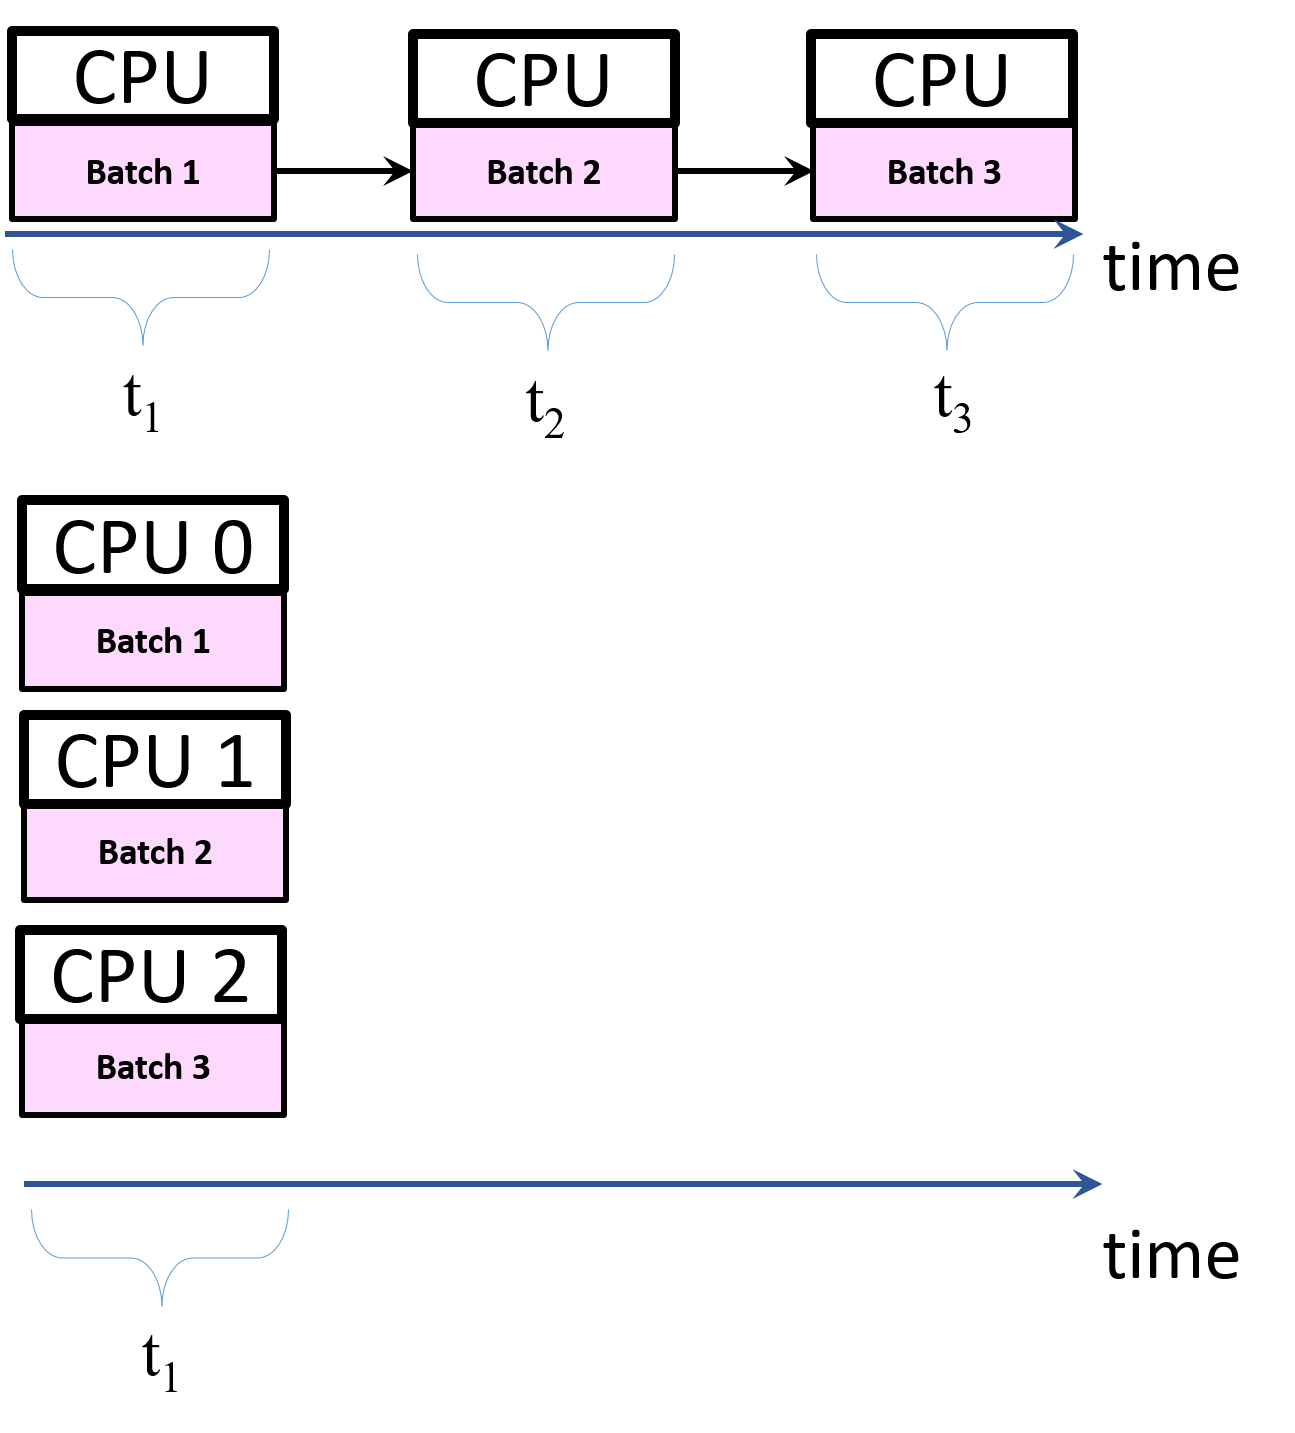
下面我們測試不同num_workers會有什麼差異。

# PyTorch DataLoader num_workers 說明

當使用 PyTorch 進行深度學習模型的訓練時，數據加載的效率對於整體訓練過程的速度有顯著影響。`DataLoader` 的 `num_workers` 參數允許開發者設定多進程數量來預加載數據，這裡提供對該參數使用的一般指南。

## 多進程與多線程

- **多線程**：在同一進程內運行的多條執行線程。儘管多線程可以共享記憶體空間，方便數據共享，但受限於 Python 的 GIL（Global Interpreter Lock），在 CPU 密集型任務上可能不會有效提高性能。

- **多進程**：運行多個獨立進程，每個進程擁有自己的記憶體空間。多進程可充分利用多核 CPU，實現真正的並行計算，從而提升數據加載和處理的速度。

## num_workers 使用指南

`num_workers` 參數設定 DataLoader 在數據加載時使用的進程數量。設定為大於 0 的值時，PyTorch 將創建相應數量的子進程來加載數據，有助於縮短 I/O 等待時間。

### 考慮因素

- **記憶體使用量**：增加 `num_workers` 將增加系統的總記憶體消耗，因為每個進程都會佔用獨立的記憶體空間。
- **I/O 性能**：如果數據加載速度不是訓練的瓶頸（如使用高速 SSD），增加 `num_workers` 可能不會帶來明顯的性能提升。
- **處理器核心數**：合理設置 `num_workers` 應考慮 CPU 核心數量，避免因進程過多而導致的效率降低。

### 最佳實踐

選擇合適的 `num_workers` 值需根據具體硬件配置和數據集特性進行調整。一般來說，適當增加 `num_workers` 可以顯著提高數據加載速度，但也要注意平衡記憶體使用和 CPU 負載。

## 結論

通過合理設定 `num_workers`，PyTorch 使用者可以在確保系統資源高效利用的同時，加速模型訓練過程中的數據加載。實踐中建議逐步調整 `num_workers` 值，以找到最佳的數據加載性能。


---

## 實驗設計 DOE

timeimplement compare w/ n_worker and batch


batch_size:2
num_workers: 0
num_workers: 2
num_workers: 4
num_workers: 6
batch_size:10
num_workers: 0
num_workers: 2
num_workers: 4
num_workers: 6
batch_size:50
num_workers: 0
num_workers: 2
num_workers: 4
num_workers: 6


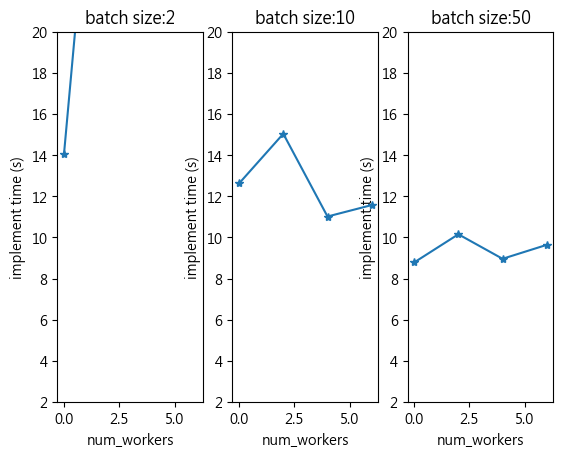

In [21]:
from torchvision import transforms
import time
import numpy as np
import matplotlib.pyplot as plt

# 下載 MNIST 資料集
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform= transforms.ToTensor())


def fun_timetest(data_loader):
    start = time.time()
    count=0
    for data, target in data_loader:
        count+=1
    timeimplement = time.time()-start
#     print("total iteration: {}, a forloop time for whole dataset within CPU: {}s".format(count, timeimplement) )
    return timeimplement

###
if __name__ == "__main__":
    for i_subplot, batch_size in enumerate([2,10,50]):
        record = []
        print("batch_size:{}".format(batch_size))
        for i in range(0,8,2):
            print("num_workers: {}".format(i))
            mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=batch_size, shuffle=False, num_workers=i) 
            timeimplement= fun_timetest(mnistdata_loader)
            record.append([i,timeimplement])
        record = np.array(record)


        plt.subplot(1,3,i_subplot+1)
        plt.plot(record[:,0],record[:,1],'*-')
        plt.ylim([2,20])
        plt.xlabel('num_workers')
        plt.ylabel('implement time (s)')
        plt.title('batch size:{}'.format(batch_size))



>num_workers 這個數字不是越高越好，一般建議設定為4~6。